# EDA: Tarifas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

from statsmodels.graphics.tsaplots import plot_acf

import torch

import pytorch_common.util    as pu
from util   import set_seed

from scipy import stats
from scipy.signal import savgol_filter

import data as dt

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
pu.set_device_name('cpu')

In [6]:
pu.get_device()

device(type='cpu')

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.12.1+cu116'

In [9]:
set_seed(42)

In [10]:
DATASET_PATH = '../datasets/tarifas.csv'

## Funciones Helper

In [ ]:
def circular_rolling_average(values, window, circular=False):    
    first_values = values[-(window-1):] if circular else np.zeros(window-1)
    values = pd.Series(np.concatenate((first_values, values)))
    return values.rolling(window=window).mean().dropna().values


def columns_as_category(df):
    return df.stack().reset_index().rename(columns={'level_1': 'column', 0: 'value'}).drop(columns=['level_0']).reset_index()


def moving_average_plot(df, column, windows=[12], freq_zoom=None, diff=False, circular=False):
    data = {'MA1': df[column].values }
    
    previous = 'MA1'
    for w in windows:
        data[f'MA{w}'] = circular_rolling_average(df[column].values, w, circular=circular)
        if diff:
            data[f'{previous}-MA{w}'] = data[previous] - data[f'MA{w}']

    time_df = columns_as_category(pd.DataFrame(data)) \
        .rename(columns={'column': 'Datos'})
    

    sns.set(rc = {'figure.figsize':(20, 8)})
    f= sns.lineplot(x="index", y='value', hue='Datos',  data=time_df, marker="o")
    dt.leyends(f, xlabel ='Tiempo', ylabel=dt.to_title(column), title=f'{dt.to_title(column)} - Dominio de Tiempo')
    plt.show()

    

    if freq_zoom is None:
        freq_zoom = len(data['MA1'])

    sns.set(rc = {'figure.figsize':(10, 15)})
    for name, values in data.items():
        values = np.abs(np.fft.fft(values))[:freq_zoom]
        f = sns.lineplot(x=list(range(len(values))), y=values, label=dt.to_title(name), marker="o")
    dt.leyends(f, xlabel ='Frecuencia', ylabel='Amplitud', title=f'{dt.to_title(column)} - Dominio de la Frecuencia')
    plt.show()

## Análisis

Cargamos el dataset y ordenamos por fecha ascendente:

In [11]:
rates = pd.read_csv(DATASET_PATH)
rates.columns = rates.columns.str.lower()

rates['date'] = rates['month'].apply(lambda x: f'01-{x}') 
rates['date'] = pd.to_datetime(rates['date'], format="%d-%m-%Y")

rates = rates.drop(columns=['month'])
rates = rates.sort_values(['date', 'empresa'], ascending=True)

rates['cargo_fijo'] = pd.to_numeric(rates['cargo_fijo'])
rates['cargo_var']  = pd.to_numeric(rates['cargo_var'])
rates['cargo_fijo_unidad'] = rates['cargo_fijo_unidad'].apply(lambda x: x.replace('.', ''))
                                                         
rates.head()

,empresa,type,cargo_fijo_unidad,cargo_fijo,cargo_var_unidad,cargo_var,date
207,EDENOR,Tarifa 1 - R2,$/bim,21.59,$/kWh,0.049,2014-01-01
206,EDESUR,Tarifa 1 - R2,$/bim,20.35,$/kWh,0.048,2014-01-01
205,EDENOR,Tarifa 1 - R2,$/bim,21.59,$/kWh,0.049,2014-02-01
204,EDESUR,Tarifa 1 - R2,$/bim,20.35,$/kWh,0.048,2014-02-01
203,EDENOR,Tarifa 1 - R2,$/bim,21.59,$/kWh,0.049,2014-03-01


In [12]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 207 to 1
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   empresa            208 non-null    object        
 1   type               208 non-null    object        
 2   cargo_fijo_unidad  208 non-null    object        
 3   cargo_fijo         208 non-null    float64       
 4   cargo_var_unidad   208 non-null    object        
 5   cargo_var          208 non-null    float64       
 6   date               208 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 13.0+ KB


Llevamos los cargos bimestrales a mensuales:

In [13]:
rates['cargo_fijo_unidad'].value_counts()

$/mes    122
$/bim     86
Name: cargo_fijo_unidad, dtype: int64

In [14]:
rates['cargo_fijo'] = np.where(rates['cargo_fijo_unidad'] == '$/bim', rates['cargo_fijo']/2, rates['cargo_fijo'])

In [15]:
rates.head()

,empresa,type,cargo_fijo_unidad,cargo_fijo,cargo_var_unidad,cargo_var,date
207,EDENOR,Tarifa 1 - R2,$/bim,10.795,$/kWh,0.049,2014-01-01
206,EDESUR,Tarifa 1 - R2,$/bim,10.175,$/kWh,0.048,2014-01-01
205,EDENOR,Tarifa 1 - R2,$/bim,10.795,$/kWh,0.049,2014-02-01
204,EDESUR,Tarifa 1 - R2,$/bim,10.175,$/kWh,0.048,2014-02-01
203,EDENOR,Tarifa 1 - R2,$/bim,10.795,$/kWh,0.049,2014-03-01


**Observaciones**

* Debido a que las tarias cambiaron de cobro bimestra a mensual se lleva todo a nivel mensual.
* Tomamos las tarigas R2 y R5 como referencia. Son tarifas recidenciales promedio.

In [16]:
edenor = rates[rates['empresa'] =='EDENOR']
edesur = rates[rates['empresa'] =='EDESUR']

### Edenor

<Figure size 1440x216 with 1 Axes>

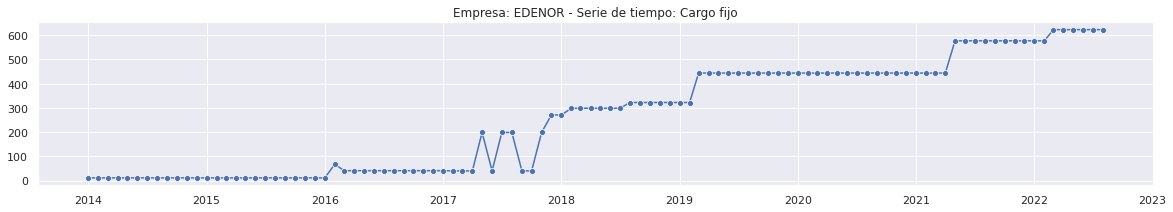

<Figure size 1440x216 with 1 Axes>

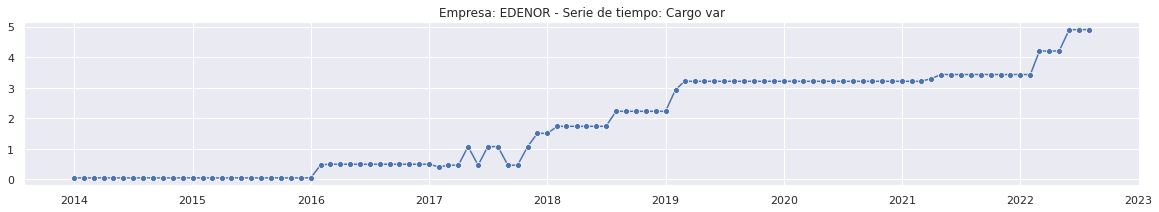

In [29]:
dt.plot_ts_var(edenor, 'date', 'cargo_fijo', title_prefix='Empresa: EDENOR - ')
dt.plot_ts_var(edenor, 'date', 'cargo_var',  title_prefix='Empresa: EDENOR - ')

**Observaciones**

* No hay gran diferencia entre ambas empresas. Las series son practicamente iguales.
* La tarifa es una serie creciente.
* No se aprecia periodicidad, debido a la inflación.
* Durante la pandemia prácticamente no hay aumentos en las tarifas.
* Se aprecian incrementos a partir del 2021 en cargos fijos y 2022 en variables.

### Edesur

<Figure size 1440x216 with 1 Axes>

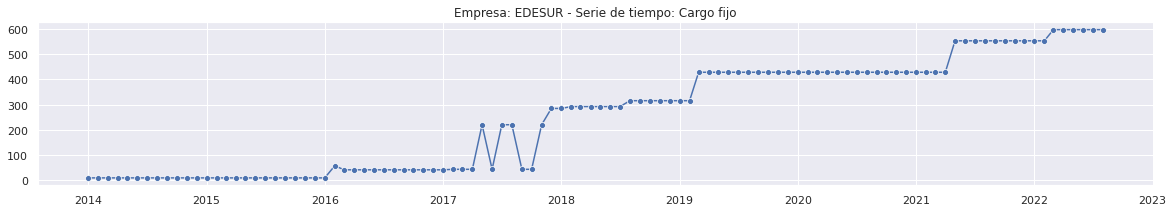

<Figure size 1440x216 with 1 Axes>

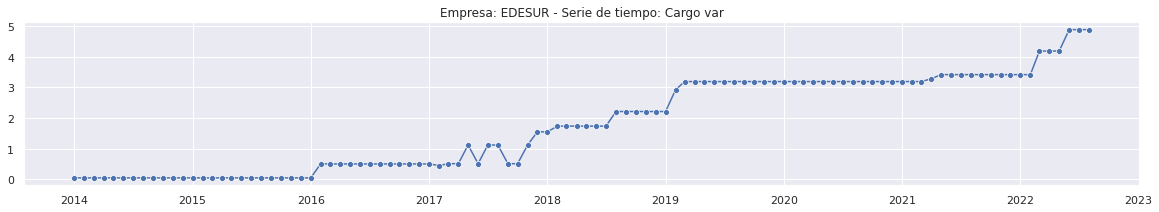

In [18]:
dt.plot_ts_var(edesur, 'date', 'cargo_fijo', title_prefix='Empresa: EDESUR - ')
dt.plot_ts_var(edesur, 'date', 'cargo_var',  title_prefix='Empresa: EDESUR - ')

## Filtro de media movil (smothing o filtro pasa bajo)


### Edenor

Cargo fijo:

In [31]:
WINDOWS = [24]

<Figure size 1440x576 with 1 Axes>

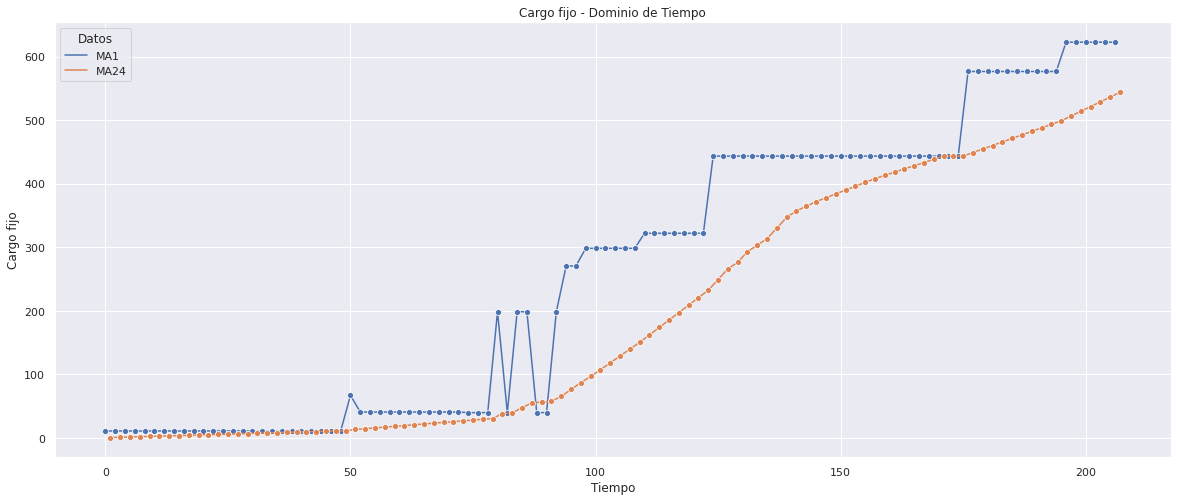

<Figure size 720x1080 with 1 Axes>

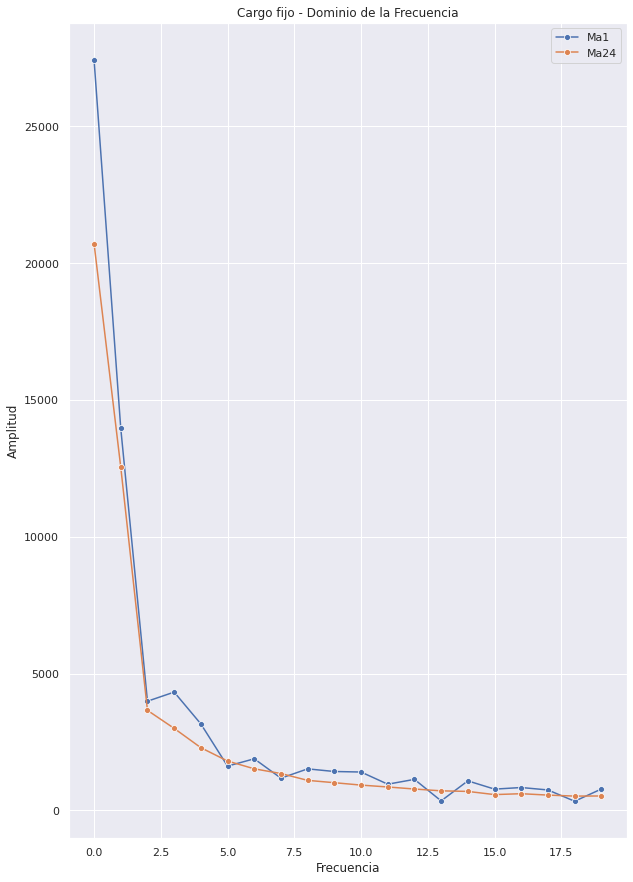

In [21]:
moving_average_plot(edenor, 'cargo_fijo', WINDOWS, freq_zoom=20)

**Observaciones**

* Cuando mas grande es la ventana de smothing, mas se aminoran las altas freciencias. 
* Por esta razón, la componente a la cual le aplicamos la media movil tiene componentes en freciencia, de menor grado que la señal original.
* M12: Vemos que se pierden lsa freciencias mas alta quedando las armanicas de mas baja frecuencia.

Cago Variable:

<Figure size 1440x576 with 1 Axes>

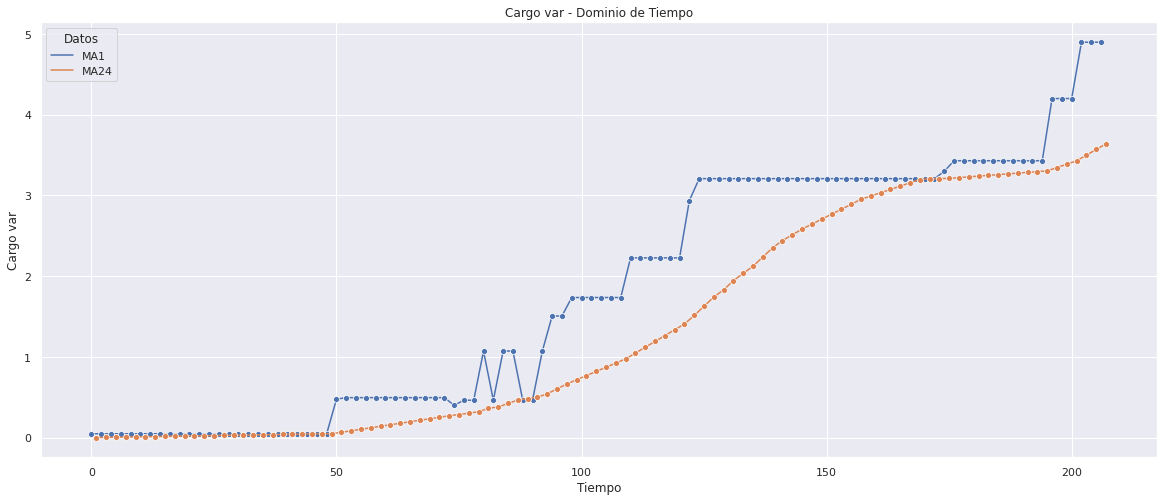

<Figure size 720x1080 with 1 Axes>

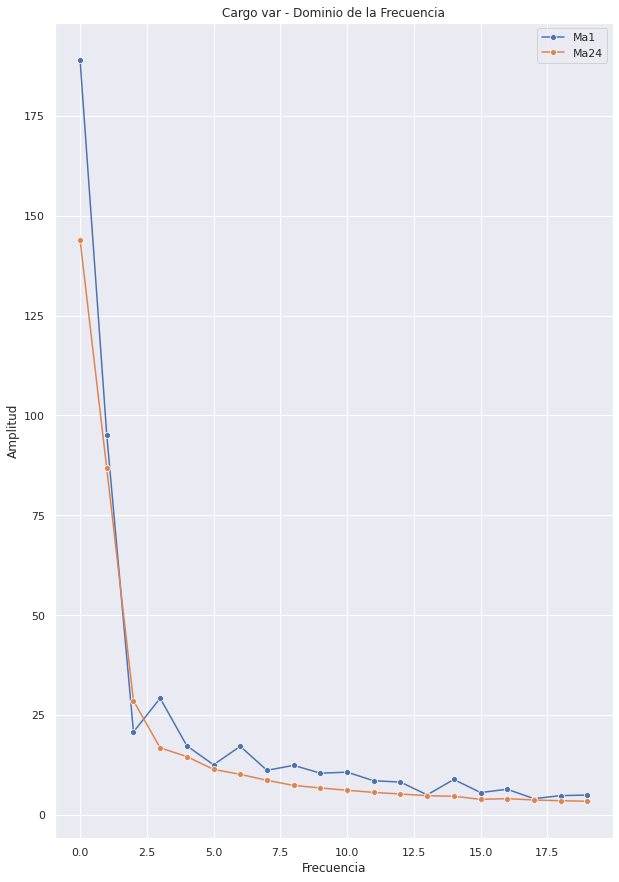

In [22]:
moving_average_plot(edenor, 'cargo_var', WINDOWS, freq_zoom=20)

### Edesur

Cargo fijo:

<Figure size 1440x576 with 1 Axes>

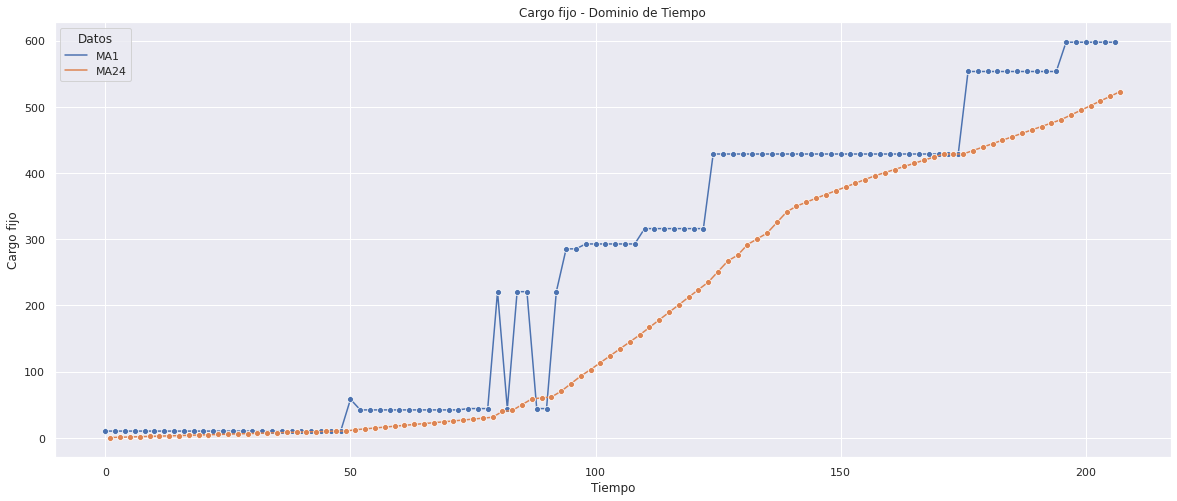

<Figure size 720x1080 with 1 Axes>

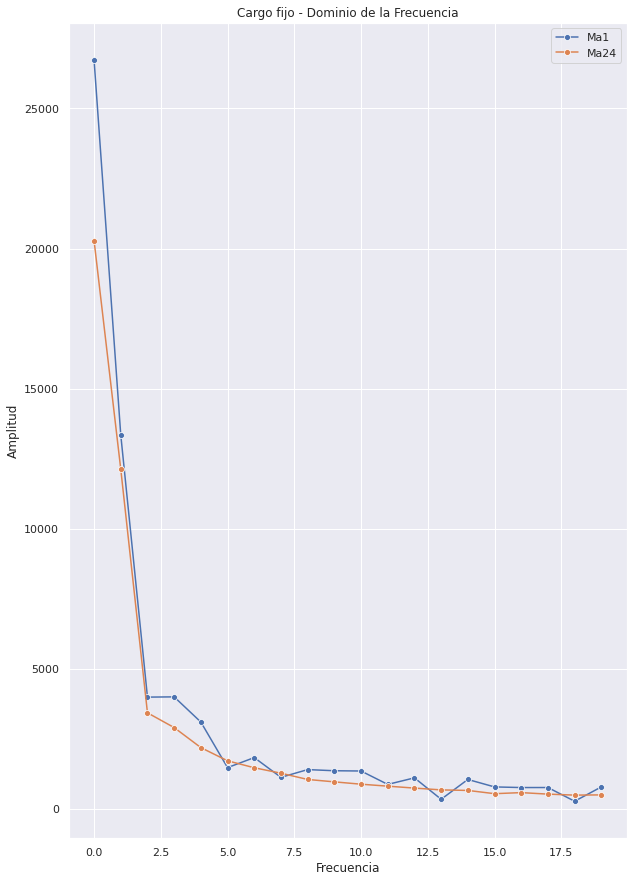

In [23]:
moving_average_plot(edesur, 'cargo_fijo', WINDOWS, freq_zoom=20)

Cargo variable:

<Figure size 1440x576 with 1 Axes>

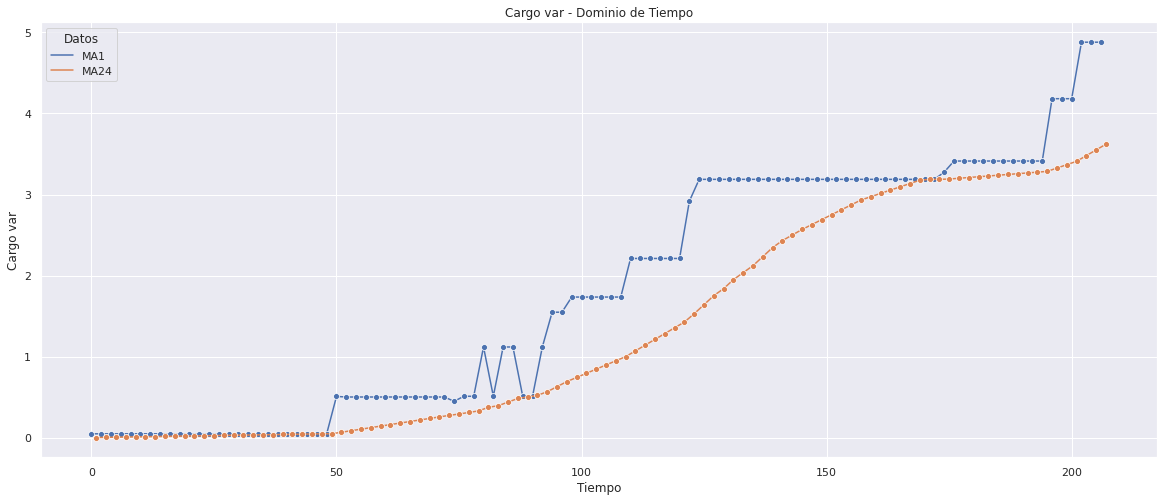

<Figure size 720x1080 with 1 Axes>

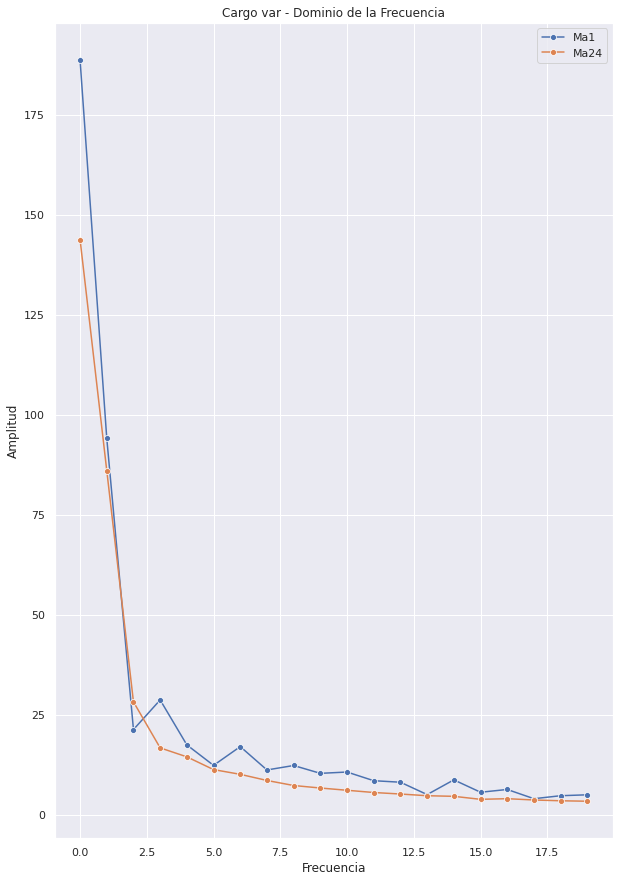

In [24]:
moving_average_plot(edesur, 'cargo_var', WINDOWS, freq_zoom=20)

## Auto correlación

La autocorrelación de la señal permite interpretar si la señal original tiene periodicidad y ruido. 

In [25]:
def acf(df, column):
    sns.set(rc = {'figure.figsize':(20, 4)})
    values = edenor[column].values
    plot_acf(x=values, lags=len(values)-1)
    plt.show()

### Edenor

<Figure size 1440x288 with 1 Axes>

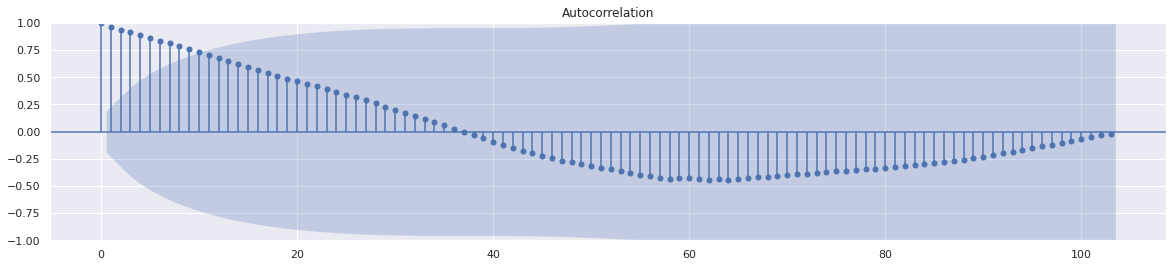

<Figure size 1440x288 with 1 Axes>

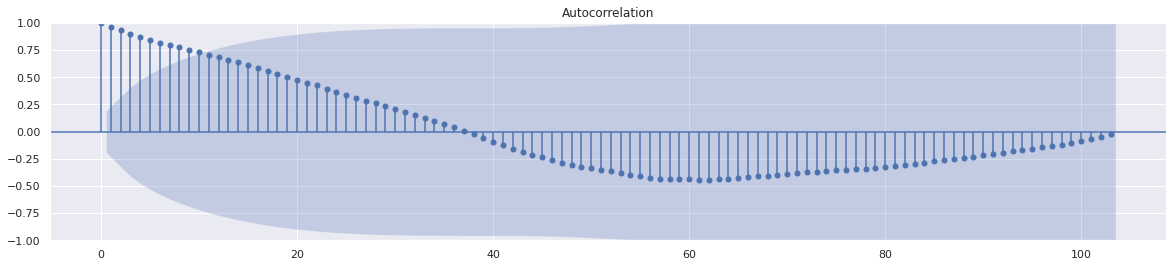

In [26]:
acf(edenor, 'cargo_fijo')
acf(edenor, 'cargo_var')

<Figure size 1440x288 with 1 Axes>

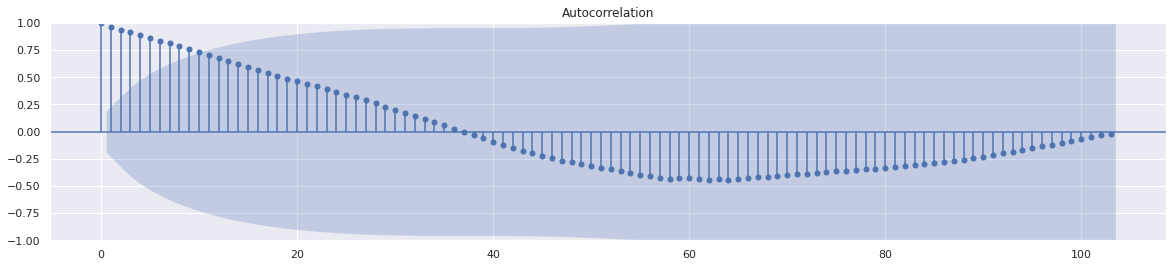

<Figure size 1440x288 with 1 Axes>

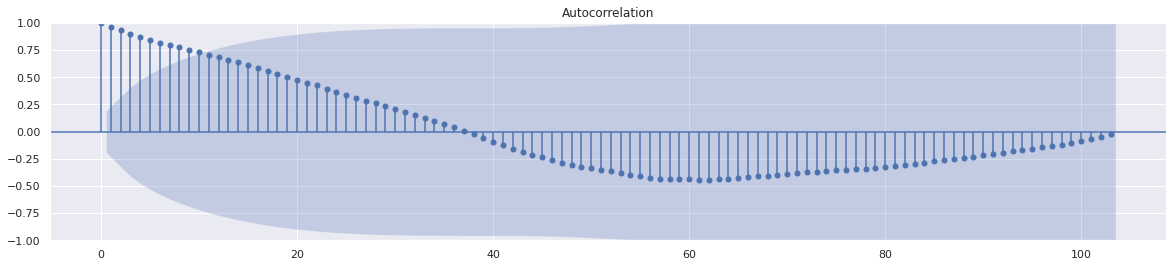

In [27]:
acf(edesur, 'cargo_fijo')
acf(edesur, 'cargo_var')

**Observaciones**

* No se aprecia periodicidad en las señales.
* Se aprecia ruido en niveles muy bajos.